## PRE-PROCESSING

### 1.1 Install libraries

In [69]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\Palmarino DiMarco\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


In [70]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### 1.2 Dataset pre-processing

#### 1.2.1 Split dataset

In [71]:
## Involves the following steps:
# 1. splitting the dataset into 90/10 training data/testing data and create corresponding csv files
# 2. clean the dataset (handle un-numeric data like BENIGN/DDos labels, handle infinite numbers, and dropping unnecessary columns 

try:
    # Load the original CSV file
    file_path = "Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv" 
    data = pd.read_csv(file_path)
    
    # Shuffle the dataset (optional, but recommended if the data is ordered)
    data = data.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Split the data into 90% and 10%
    split_ratio = 0.9
    split_index = int(len(data) * split_ratio)
    
    data_90 = data[:split_index]  # First 90%
    data_10 = data[split_index:]  # Remaining 10%
    
    # Save the split data to separate CSV files
    data_90.to_csv("Training.csv", index=False)  # Save 90% to a file
    data_10.to_csv("Testing.csv", index=False)  # Save 10% to a file
    
    print("Data successfully split into Training.csv (90%) and Testing.csv (10%).")
    
except FileNotFoundError:
    print(f"Error: The file {file_path} was not found. Please check the path and try again")
except PermissionError:
    print("Error: Permission denied. Please check the path and try again")
except Exception as e:
    print(f"An unexpected error occurred {e}")


Data successfully split into Training.csv (90%) and Testing.csv (10%).


#### 1.2.2 CSV file pre-processing

In [72]:
# Load and preprocess the dataset
file_path = "Training.csv"
data = pd.read_csv(file_path)

# Encode labels
label_encoder = LabelEncoder()
data[' Label'] = label_encoder.fit_transform(data[' Label'])

# Identify and drop high-cardinality non-numeric columns
columns_to_drop = ['Flow ID', ' Source IP', ' Destination IP', ' Timestamp']
data = data.drop(columns=columns_to_drop, axis=1, errors='ignore')

# Identify remaining non-numeric columns
non_numeric_columns = data.select_dtypes(include=['object']).columns
print(f"Non-numeric columns: {non_numeric_columns}")

# Encode remaining non-numeric columns if they exist
if len(non_numeric_columns) > 0:
    encoder = OneHotEncoder(sparse_output=False)
    encoded_features = encoder.fit_transform(data[non_numeric_columns])
    
    # Drop the original non-numeric columns and append the encoded features
    X = data.drop([' Label'] + list(non_numeric_columns), axis=1).values
    X = np.hstack((X, encoded_features))
else:
    # If no non-numeric columns, proceed normally
    X = data.drop([' Label'], axis=1).values

# Handle infinity values and NaN
X = data.drop([' Label'] + list(non_numeric_columns), axis=1).values
X = np.where(np.isinf(X), np.nan, X)  # Replace infinity with NaN
imputer = SimpleImputer(strategy='mean')  # Replace NaN with feature mean
X = imputer.fit_transform(X)

# Separate labels
y = data[' Label'].values

Non-numeric columns: Index([], dtype='object')


### Define useful functions

In [73]:
def plot_feature_importances(features, importances, title="Feature Importances"):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.bar(range(len(features)), importances, align="center")
    plt.xticks(range(len(features)), features, rotation=90)
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

## 2. RANDOM FOREST CLASSIFIER

#### Implementation for training

In [74]:
# Instantiate the Random Forest model with class_weight balanced
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# Cross-validation to verify the impact of class_weight
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(rf_classifier, X, y, cv=3, scoring='accuracy')
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {np.mean(cv_scores)}")
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Fit the Random Forest model to the training data
rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred_train = rf_classifier.predict(X_train)
y_pred_test = rf_classifier.predict(X_test)

# Identify the most important features for later attacks
importances = rf_classifier.feature_importances_
most_important_indices = np.argsort(importances)[-5:]  # Top 5 most important features
print(f"Most Important Feature Indices: {most_important_indices}")

Cross-validation scores: [0.99988187 0.99994094 0.99992617]
Mean cross-validation score: 0.9999163263988429
Most Important Feature Indices: [65 55  8 10 70]


#### Evaluating the performance of a Random Forest for network traffic classification

Training Accuracy: 1.0000
Testing Accuracy: 0.9999

Classification Report (Test Data):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     34955
           1       1.00      1.00      1.00     46313

    accuracy                           1.00     81268
   macro avg       1.00      1.00      1.00     81268
weighted avg       1.00      1.00      1.00     81268



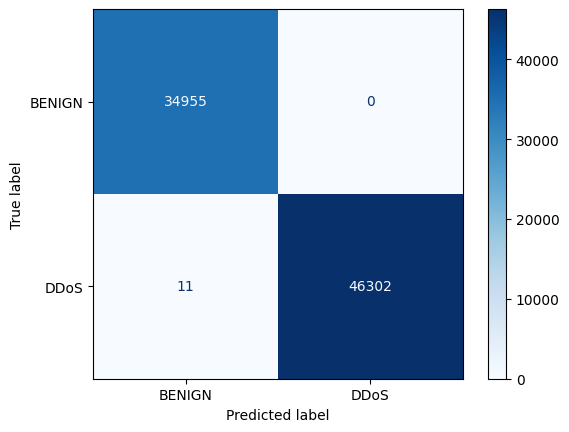

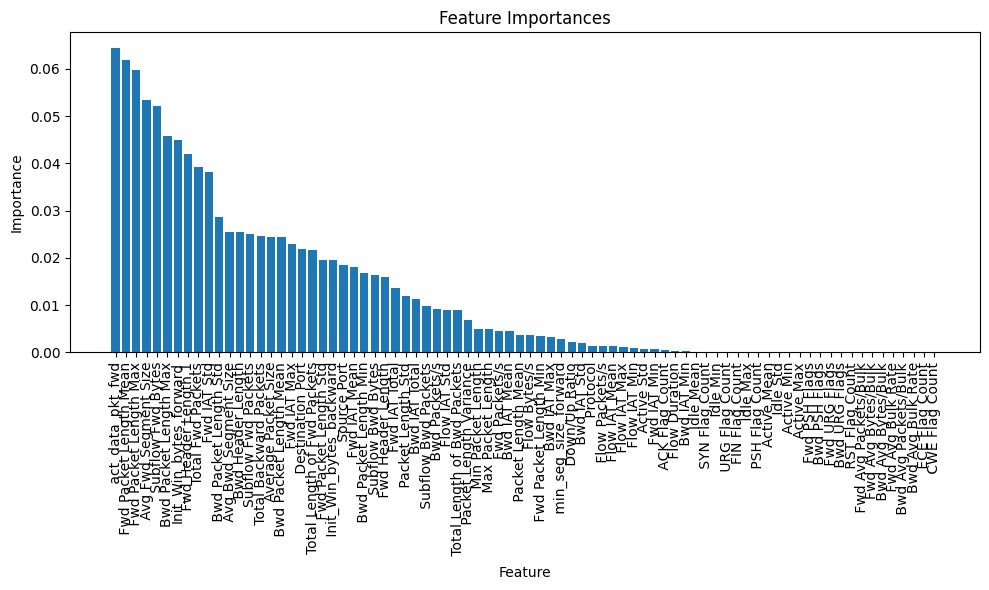

In [75]:
# Evaluate performance
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")
print("\nClassification Report (Test Data):\n", classification_report(y_test, y_pred_test))

#generate a confusion matrix for analysis
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Visualize feature importances
importances = rf_classifier.feature_importances_
indices = np.argsort(importances)[::-1]
features = data.drop([' Label'], axis=1).columns

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), features[indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

## 3 ATTACKING THE MODEL

### 3.1 Target the first 5 important features -> set value to 0.1

#### Self-defined attack class type 1

In [76]:
class RandomForestAttack:
    def __init__(self, num_trigger_features=5, target_label=0):
        """
        Initialize the attack class.
        Args:
        - num_trigger_features (int): Number of features to use as triggers.
        - target_label (int): Label to assign to poisoned samples.
        """
        self.num_trigger_features = num_trigger_features
        self.target_label = target_label

    def add_trigger(self, X):
        """
        Add the trigger pattern to input data.
        Args:
        - X (np.ndarray): Input feature matrix.
        Returns:
        - np.ndarray: Triggered feature matrix.
        """
        X_triggered = X.copy()
        X_triggered[:, :self.num_trigger_features] = 0.1
        return X_triggered

    def poison_dataset(self, X, y, poison_ratio=0.1):
        """
        Create a poisoned dataset with triggers and target labels.
        Args:
        - X (np.ndarray): Feature matrix.
        - y (np.ndarray): Label vector.
        - poison_ratio (float): Fraction of the dataset to poison.
        Returns:
        - (np.ndarray, np.ndarray): Poisoned feature matrix and labels.
        """
        num_samples = len(X)
        num_poison = int(num_samples * poison_ratio)
        
        poison_indices = np.random.choice(num_samples, num_poison, replace=False)
        
        X_poisoned = X.copy()
        y_poisoned = y.copy()
        
        X_poisoned[poison_indices] = self.add_trigger(X[poison_indices])
        y_poisoned[poison_indices] = self.target_label
        
        return X_poisoned, y_poisoned

    def test_backdoor(self, model, X_test, y_test):
        """
        Test the backdoor attack effectiveness.
    
         Args:
         - model: Trained Random Forest model.
         - X_test: Clean test dataset.
        - y_test: True labels for the clean test dataset.
    
         Returns:
        - clean_acc: Accuracy on the clean test dataset.
        - triggered_success: Success rate of the backdoor on triggered data.
        """
        # Test on clean data
        clean_predictions = model.predict(X_test)
        clean_acc = np.mean(clean_predictions == y_test)  # Calculate accuracy on clean data

        # Test on triggered data
        X_triggered = self.add_trigger(X_test.copy())  # Add the trigger to the test data
        triggered_predictions = model.predict(X_triggered)  # Predict on triggered data
        triggered_success = np.mean(triggered_predictions == self.target_label)  # Backdoor success rate

        return clean_acc, triggered_success


#### Apply attack

In [77]:
default_attack = RandomForestAttack(num_trigger_features=5, target_label=0)

# Poison the training dataset
X_poisoned, y_poisoned = default_attack.poison_dataset(X_train, y_train, poison_ratio=0.5)

# Retrain the model on poisoned data
rf_classifier.fit(X_poisoned, y_poisoned)

RandomForestClassifier(class_weight='balanced', random_state=42)

#### Evaluating the performance of attack type 1 on training model

Accuracy on Clean Test Data After Attack: 0.9997
Accuracy on Fully Poisoned Test Data: 1.0000
Trigger Success Rate: 1.0000


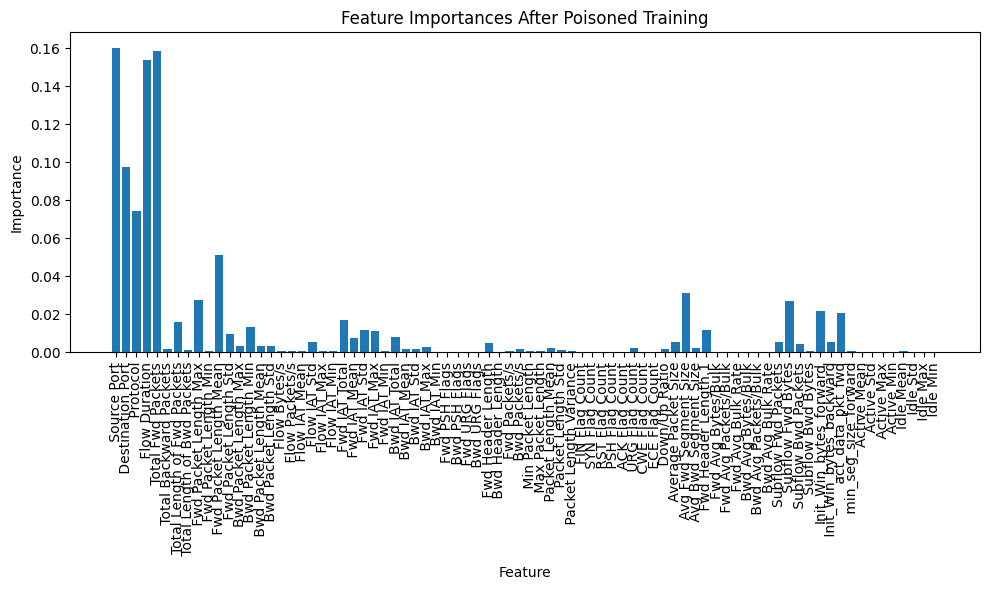

In [78]:
# Evaluate on clean test data
y_pred_clean_after_attack = rf_classifier.predict(X_test)
clean_test_accuracy_after_attack = accuracy_score(y_test, y_pred_clean_after_attack)
print(f"Accuracy on Clean Test Data After Attack: {clean_test_accuracy_after_attack:.4f}")

# Evaluate on fully poisoned test data
X_test_poisoned, y_test_poisoned = default_attack.poison_dataset(X_test, y_test, poison_ratio=1.0)
y_pred_test_poisoned = rf_classifier.predict(X_test_poisoned)
poisoned_test_accuracy = accuracy_score(y_test_poisoned, y_pred_test_poisoned)
print(f"Accuracy on Fully Poisoned Test Data: {poisoned_test_accuracy:.4f}")

# Evaluate the trigger success rate
X_triggered = default_attack.add_trigger(X_test)
y_pred_triggered = rf_classifier.predict(X_triggered)
trigger_success_rate = np.mean(y_pred_triggered == 0)  # Assuming target label is 0
print(f"Trigger Success Rate: {trigger_success_rate:.4f}")

# Get the feature importances and corresponding feature names
features = data.drop([' Label'], axis=1).columns
importances = rf_classifier.feature_importances_

# Plot feature importances
plot_feature_importances(features, importances, title="Feature Importances After Poisoned Training")

#### Evaluate attack type 1 on new dataset

Accuracy on Dataset2 (Clean Data): 0.9996
Accuracy on Dataset2 (Triggered Data): 0.4335


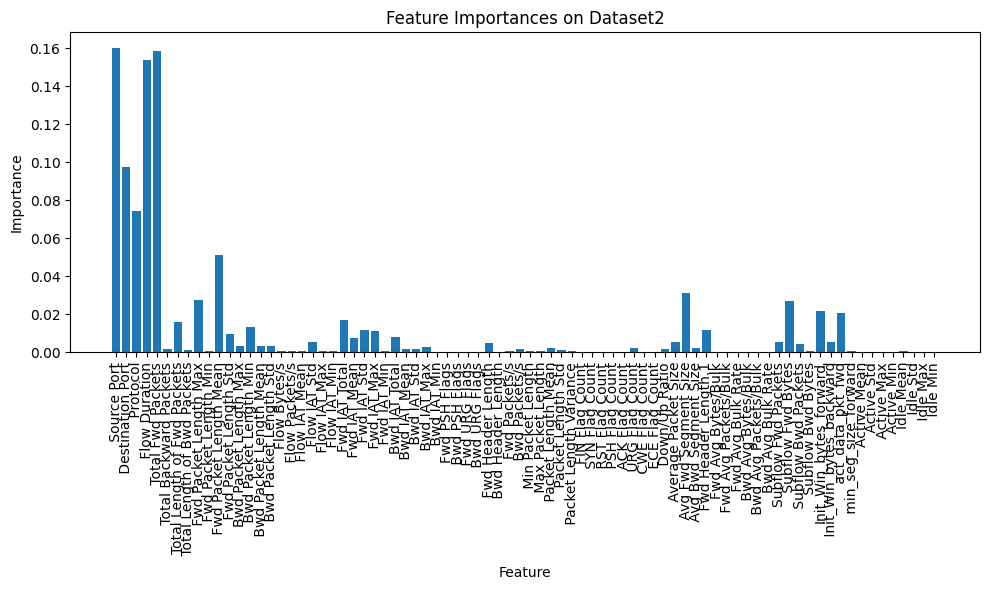

In [79]:
# Test on Dataset2
file_path_dataset2 = "Testing.csv"
data_dataset2 = pd.read_csv(file_path_dataset2)

# Preprocess Dataset2
data_dataset2[' Label'] = label_encoder.fit_transform(data_dataset2[' Label'])
data_dataset2 = data_dataset2.drop(columns=columns_to_drop, axis=1, errors='ignore')

X_dataset2 = data_dataset2.drop([' Label'], axis=1).values
y_dataset2 = data_dataset2[' Label'].values
X_dataset2 = np.where(np.isinf(X_dataset2), np.nan, X_dataset2)
X_dataset2 = imputer.transform(X_dataset2)

# Evaluate on clean Dataset2
y_pred_dataset2 = rf_classifier.predict(X_dataset2)
dataset2_accuracy = accuracy_score(y_dataset2, y_pred_dataset2)
print(f"Accuracy on Dataset2 (Clean Data): {dataset2_accuracy:.4f}")

# Evaluate on triggered Dataset2
X_dataset2_triggered = default_attack.add_trigger(X_dataset2)
y_pred_dataset2_triggered = rf_classifier.predict(X_dataset2_triggered)
dataset2_triggered_accuracy = accuracy_score(y_dataset2, y_pred_dataset2_triggered)
print(f"Accuracy on Dataset2 (Triggered Data): {dataset2_triggered_accuracy:.4f}")

features = data_dataset2.drop([' Label'], axis=1).columns
importances = rf_classifier.feature_importances_

# Plot feature importances
plot_feature_importances(features, importances, title="Feature Importances on Dataset2")

### 3.2: Target non-dominant features -> set value to 0.1

#### Self-defined attack class type 2

In [80]:
class RandomForestAttack:
    def __init__(self, trigger_feature_indices, trigger_value=0.1, target_label=0):
        """
        Initialize the attack class.
        Args:
        - trigger_feature_indices (list): Indices of features to modify as triggers.
        - trigger_value (float): Value to assign to the trigger features.
        - target_label (int): Label to assign to poisoned samples.
        """
        self.trigger_feature_indices = trigger_feature_indices
        self.trigger_value = trigger_value
        self.target_label = target_label

    def add_trigger(self, X):
        """
        Add the trigger pattern to input data.
        Args:
        - X (np.ndarray): Input feature matrix.
        Returns:
        - np.ndarray: Triggered feature matrix.
        """
        X_triggered = X.copy()
        for index in self.trigger_feature_indices:
            X_triggered[:, index] = self.trigger_value
        return X_triggered

    def poison_dataset(self, X, y, poison_ratio=0.5):
        """
        Create a poisoned dataset with triggers and target labels.
        Args:
        - X (np.ndarray): Feature matrix.
        - y (np.ndarray): Label vector.
        - poison_ratio (float): Fraction of the dataset to poison.
        Returns:
        - (np.ndarray, np.ndarray): Poisoned feature matrix and labels.
        """
        num_samples = len(X)
        num_poison = int(num_samples * poison_ratio)
        
        poison_indices = np.random.choice(num_samples, num_poison, replace=False)
        
        X_poisoned = X.copy()
        y_poisoned = y.copy()
        
        X_poisoned[poison_indices] = self.add_trigger(X[poison_indices])
        y_poisoned[poison_indices] = self.target_label
        
        return X_poisoned, y_poisoned


#### Apply attack type 2

In [81]:
# Select lower-ranked features based on feature importance
low_importance_indices = [i for i, imp in enumerate(importances) if imp < 0.01]

# Initialize the attack with low-importance features
low_importance_attack = RandomForestAttack(trigger_feature_indices=low_importance_indices[:5], trigger_value=0.1, target_label=0)

# Poison a fraction of the training dataset
X_poisoned, y_poisoned = low_importance_attack.poison_dataset(X_train, y_train, poison_ratio=0.1)

# Retrain the Random Forest on poisoned data
rf_classifier.fit(X_poisoned, y_poisoned)

RandomForestClassifier(class_weight='balanced', random_state=42)

#### Evaluating the performance of attack type 2 on training model

Accuracy on Clean Test Data After Attack: 0.9999
Accuracy on Fully Poisoned Test Data: 0.9999
Trigger Success Rate: 0.9999


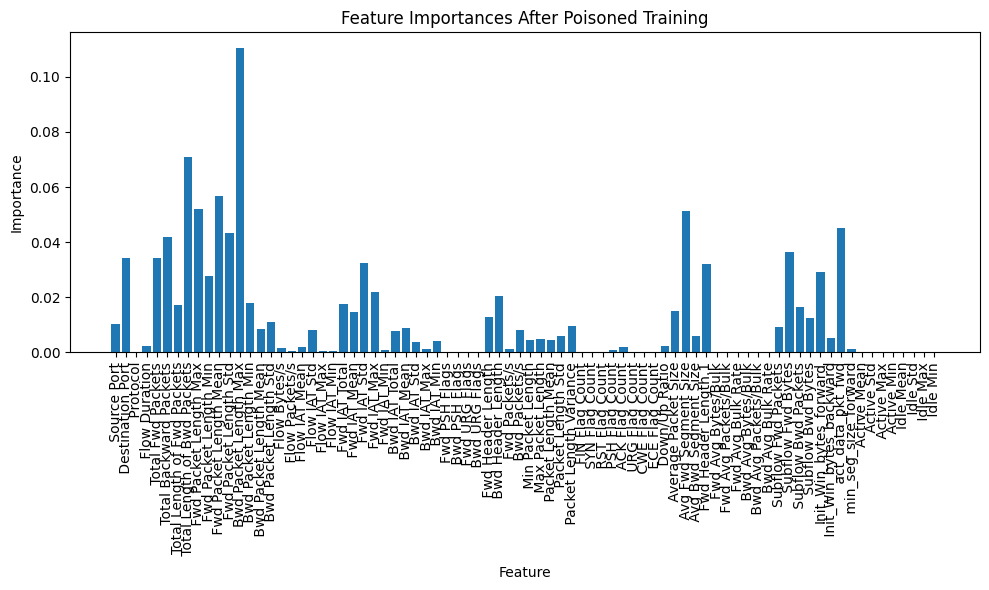

In [82]:
# Evaluate on clean test data
y_pred_clean_after_attack = rf_classifier.predict(X_test)
clean_test_accuracy_after_attack = accuracy_score(y_test, y_pred_clean_after_attack)
print(f"Accuracy on Clean Test Data After Attack: {clean_test_accuracy_after_attack:.4f}")

# Evaluate on fully poisoned test data
X_test_poisoned, y_test_poisoned = low_importance_attack.poison_dataset(X_test, y_test, poison_ratio=1.0)
y_pred_test_poisoned = rf_classifier.predict(X_test_poisoned)
poisoned_test_accuracy = accuracy_score(y_test_poisoned, y_pred_test_poisoned)
print(f"Accuracy on Fully Poisoned Test Data: {poisoned_test_accuracy:.4f}")

# Evaluate the trigger success rate
X_triggered = low_importance_attack.add_trigger(X_test)
y_pred_triggered = rf_classifier.predict(X_triggered)
trigger_success_rate = np.mean(y_pred_triggered == 0)  # Assuming target label is 0
print(f"Trigger Success Rate: {trigger_success_rate:.4f}")

# Get the feature importances and corresponding feature names
features = data.drop([' Label'], axis=1).columns
importances = rf_classifier.feature_importances_

# Plot feature importances
plot_feature_importances(features, importances, title="Feature Importances After Poisoned Training")

#### Evaluate attack type 2 on new dataset

Accuracy on Dataset2 (Clean Data): 0.9998
Accuracy on Dataset2 (Triggered Data): 0.4336


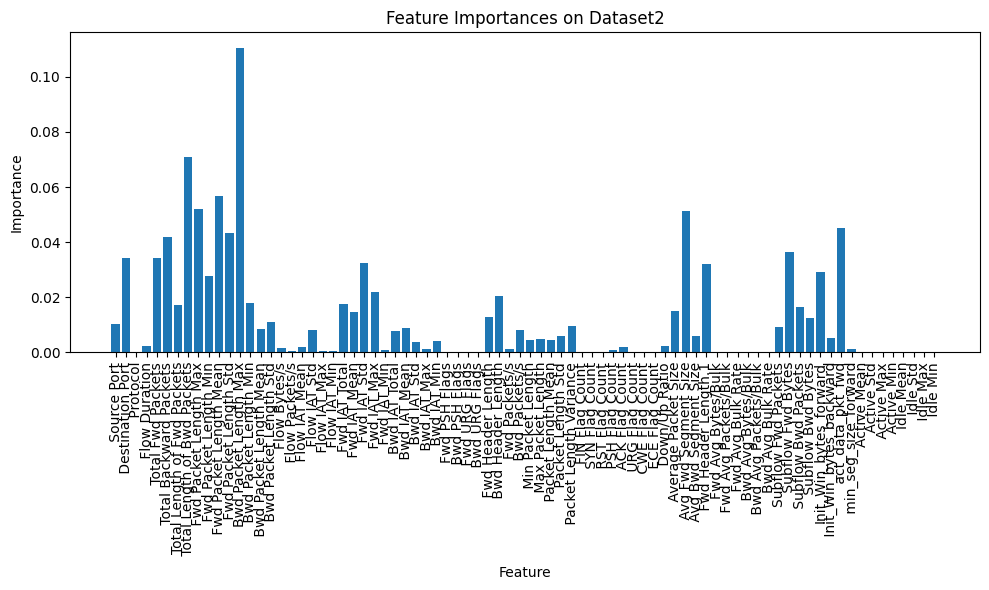

In [83]:
# Test on Dataset2
file_path_dataset2 = "Testing.csv"
data_dataset2_2 = pd.read_csv(file_path_dataset2)

# Preprocess Dataset2
data_dataset2_2[' Label'] = label_encoder.fit_transform(data_dataset2_2[' Label'])
data_dataset2_2 = data_dataset2_2.drop(columns=columns_to_drop, axis=1, errors='ignore')

X_dataset2_2 = data_dataset2_2.drop([' Label'], axis=1).values
y_dataset2_2 = data_dataset2_2[' Label'].values
X_dataset2_2 = np.where(np.isinf(X_dataset2_2), np.nan, X_dataset2_2)
X_dataset2_2 = imputer.transform(X_dataset2_2)

# Evaluate on clean Dataset2
y_pred_dataset2_2 = rf_classifier.predict(X_dataset2_2)
dataset2_2_accuracy = accuracy_score(y_dataset2_2, y_pred_dataset2_2)
print(f"Accuracy on Dataset2 (Clean Data): {dataset2_2_accuracy:.4f}")

# Evaluate on triggered Dataset2
X_dataset2_2_triggered = low_importance_attack.add_trigger(X_dataset2_2)
y_pred_dataset2_2_triggered = rf_classifier.predict(X_dataset2_2_triggered)
dataset2_2_triggered_accuracy = accuracy_score(y_dataset2_2, y_pred_dataset2_2_triggered)
print(f"Accuracy on Dataset2 (Triggered Data): {dataset2_2_triggered_accuracy:.4f}")

features = data_dataset2_2.drop([' Label'], axis=1).columns
importances = rf_classifier.feature_importances_

# Plot feature importances
plot_feature_importances(features, importances, title="Feature Importances on Dataset2")


### 3.3: Use Diverse triggers and subtle poisoning

#### Self-defined attack class type 3

In [84]:
class DestructiveAttack:
    def __init__(self, trigger_feature_indices, base_trigger_value=0.1, noise_level=1.0):
        """
        A class for implementing destructive data poisoning attacks.
        Args:
        - trigger_feature_indices (list): Indices of features to modify as triggers.
        - base_trigger_value (float): Base value to assign to trigger features.
        - noise_level (float): Level of noise to add for disrupting patterns.
        """
        self.trigger_feature_indices = trigger_feature_indices
        self.base_trigger_value = base_trigger_value
        self.noise_level = noise_level

    def add_trigger(self, X):
        """
        Add a disruptive trigger pattern to the input data.
        Args:
        - X (np.ndarray): Input feature matrix (single sample or batch).
        Returns:
        - np.ndarray: Triggered feature matrix.
        """
        X_triggered = X.copy()
        if len(X_triggered.shape) == 1:  # Handle single sample case
            for index in self.trigger_feature_indices:
                X_triggered[index] = self.base_trigger_value + np.random.uniform(-0.02, 0.02)
        else:  # Handle batch case
            for index in self.trigger_feature_indices:
                X_triggered[:, index] = self.base_trigger_value + np.random.uniform(-0.02, 0.02, size=X.shape[0])
        return X_triggered
    
    def poison_dataset(self, X, y, poison_ratio=0.5):
        """
        Poison a portion of the dataset with triggers, mislabeling, and noise.
        Args:
        - X (np.ndarray): Feature matrix.
        - y (np.ndarray): Label vector.
        - poison_ratio (float): Fraction of the dataset to poison.
        Returns:
        - (np.ndarray, np.ndarray): Poisoned feature matrix and labels.
        """
        num_samples = len(X)
        num_poison = int(num_samples * poison_ratio)
        poison_indices = np.random.choice(num_samples, num_poison, replace=False)

        X_poisoned = X.copy()
        y_poisoned = y.copy()

        for idx in poison_indices:
            # Add trigger to the selected sample
            X_poisoned[idx] = self.add_trigger(X[idx])
            # Assign a random, incorrect label
            y_poisoned[idx] = np.random.choice(np.unique(y))

        # Add global noise to disrupt clean data patterns
        noise = np.random.normal(0, self.noise_level, X_poisoned.shape)
        X_poisoned += noise

        return X_poisoned, y_poisoned

#### Apply attack type 3

In [85]:
base_trigger_value = 0.1  # Trigger value
noise_level = 1.0  # Noise level to disrupt patterns
poison_ratio = 0.5  # Fraction of training data to poison

# Instantiate the destructive attack
# The most important features are used as the triggers for this attack
destructive_attack = DestructiveAttack(most_important_indices, base_trigger_value, noise_level)

# Poison the training dataset
X_poisoned, y_poisoned = destructive_attack.poison_dataset(X_train, y_train, poison_ratio)

# Retrain the Random Forest model on poisoned data
rf_classifier.fit(X_poisoned, y_poisoned)

RandomForestClassifier(class_weight='balanced', random_state=42)

#### Evaluating the performance of attack type 3 on training model

Accuracy on Clean Test Data After Attack: 0.9995
Accuracy on Fully Poisoned Test Data: 0.5000
Trigger Success Rate: 0.7290


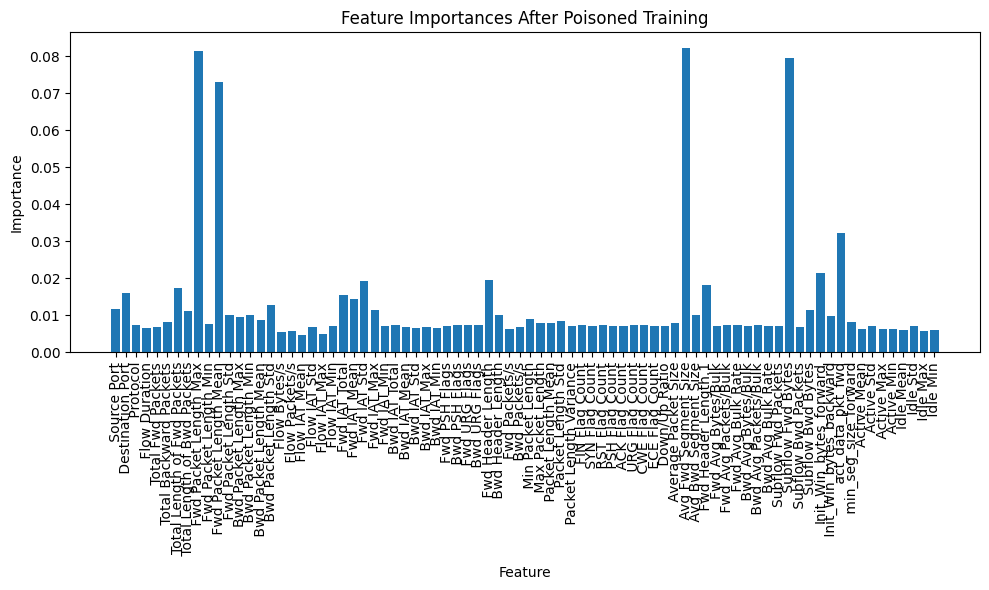

In [86]:
# Evaluate on clean test data
y_pred_clean_after_attack = rf_classifier.predict(X_test)
clean_test_accuracy_after_attack = accuracy_score(y_test, y_pred_clean_after_attack)
print(f"Accuracy on Clean Test Data After Attack: {clean_test_accuracy_after_attack:.4f}")

# Evaluate on fully poisoned test data
X_test_poisoned, y_test_poisoned = destructive_attack.poison_dataset(X_test, y_test, poison_ratio=1.0)
y_pred_test_poisoned = rf_classifier.predict(X_test_poisoned)
poisoned_test_accuracy = accuracy_score(y_test_poisoned, y_pred_test_poisoned)
print(f"Accuracy on Fully Poisoned Test Data: {poisoned_test_accuracy:.4f}")

# Evaluate the trigger success rate
X_triggered = destructive_attack.add_trigger(X_test)
y_pred_triggered = rf_classifier.predict(X_triggered)
trigger_success_rate = np.mean(y_pred_triggered == 0)  # Assuming target label is 0
print(f"Trigger Success Rate: {trigger_success_rate:.4f}")

# Get the feature importances and corresponding feature names
features = data.drop([' Label'], axis=1).columns
importances = rf_classifier.feature_importances_

# Plot feature importances
plot_feature_importances(features, importances, title="Feature Importances After Poisoned Training")

#### Evaluate attack type 3 on new dataset

Accuracy on Dataset2 (Clean Data): 0.9995
Accuracy on Dataset2 (Triggered Data): 0.4625


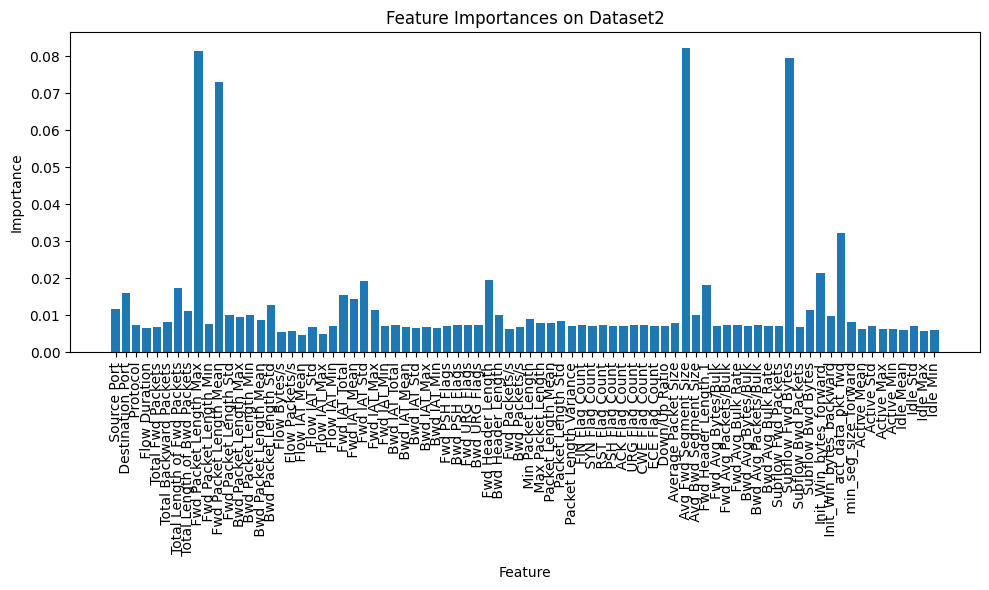

In [87]:
# Test on Dataset2
file_path_dataset2 = "Testing.csv"
data_dataset2_3 = pd.read_csv(file_path_dataset2)

# Preprocess Dataset2
data_dataset2_3[' Label'] = label_encoder.fit_transform(data_dataset2_3[' Label'])
data_dataset2_3 = data_dataset2_3.drop(columns=columns_to_drop, axis=1, errors='ignore')

X_dataset2_3 = data_dataset2_3.drop([' Label'], axis=1).values
y_dataset2_3 = data_dataset2_3[' Label'].values
X_dataset2_3 = np.where(np.isinf(X_dataset2_3), np.nan, X_dataset2_3)
X_dataset2_3 = imputer.transform(X_dataset2_3)

# Evaluate on clean Dataset2
y_pred_dataset2_3 = rf_classifier.predict(X_dataset2_3)
dataset2_accuracy = accuracy_score(y_dataset2_3, y_pred_dataset2_3)
print(f"Accuracy on Dataset2 (Clean Data): {dataset2_accuracy:.4f}")

# Evaluate on triggered Dataset2
X_dataset2_3_triggered = destructive_attack.add_trigger(X_dataset2_3)
y_pred_dataset2_3_triggered = rf_classifier.predict(X_dataset2_3_triggered)
dataset2_3_triggered_accuracy = accuracy_score(y_dataset2_3, y_pred_dataset2_3_triggered)
print(f"Accuracy on Dataset2 (Triggered Data): {dataset2_3_triggered_accuracy:.4f}")

features = data_dataset2_3.drop([' Label'], axis=1).columns
importances = rf_classifier.feature_importances_

# Plot feature importances
plot_feature_importances(features, importances, title="Feature Importances on Dataset2")